# 1 Setup
Additional information about what the values in each column of the ICA data mean can be found here:
https://www.pge.com/b2b/distribution-resource-planning/downloads/integration-capacity/PGE_ICA_Map_User_Guide.pdf

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

# Documentation for how to use data here: https://www.pge.com/b2b/distribution-resource-planning/downloads/integration-capacity/PGE_ICA_Map_User_Guide.pdf
gdb_path = "../data/raw/iou_pge/ICADisplay.gdb"

# List all layers
layers = fiona.listlayers(gdb_path)
# [
# 'LineDetail',
# 'ICANotAvailable', 
# 'FeederDetail', 
# 'Substations', 
# 'FeederLoadProfile', 
# 'SubstationLoadProfile', 
# 'TransmissionLines', 
# 'networkedSecondaryBuffer', 
# 'FeederSubstationSummary', 
# 'ICAEstimatedCapacitySummary'
# ]

In [5]:
feeder = gpd.read_file("../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
feeder_load = gpd.read_file("../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="FeederLoadProfile")

line = gpd.read_file("../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="LineDetail")

substations = gpd.read_file("../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="Substations")
substation_load = gpd.read_file("../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="SubstationLoadProfile")

# Print names of columns
dataframes = {
    'feeder': feeder,
    'feeder_load': feeder_load,
    'line': line,
    'substations': substations,
    'substation_load': substation_load
}

# Printing column keys in a table format
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.columns.tolist())
    print()

DataFrame: feeder
['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', 'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM', 'Shape_Length', 'geometry']

DataFrame: feeder_load
['FeederID', 'MonthHour', 'Light', 'High', 'geometry']

DataFrame: line
['FeederId', 'FeederName', 'Globalid', 'CSV_LineSection', 'ICA_Analysis_Date', 'LoadCapacity_kW', 'GenCapacity_kW', 'GenericPVCapacity_kW', 'GenCapacity_no_OpFlex_kW', 'GenericCapacity_no_OpFlex_kW', 'Shape_Length', 'geometry']

DataFrame: substations
['SUBNAME', 'SUBSTATIONID', 'MIN_KV', 'NUMBANKS', 'REDACTED', 'OBJECTID', 'UNGROUNDEDBANKS', 'geometry']

DataFrame: substation_load
['SubName', 'SubID', 'MonthHour', 'Light', 'High', 'geometry']



In [6]:
# Counts of each

pairs = [
    ('feeder', feeder, 'FeederID'),
    ('line', line, 'Globalid'),
    ('substations', substations, 'SUBSTATIONID')
]

for df_name, dataframe, column_name in pairs:
    print(f"{df_name}[{column_name}] count: {dataframe[column_name].count()}")

feeder[FeederID] count: 3016
line[Globalid] count: 1232039
substations[SUBSTATIONID] count: 740


## Shared preparation

In [7]:
columns_to_select = ['FeederID', 'Feeder_Name', 'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'geometry']

# 2. PG&E - Geometry segments with most customers, top 5

In [8]:
feeder_most_customers = feeder.nlargest(100, 'ResCust')
top_5_feeders_customers = feeder_most_customers[columns_to_select]

top_5_feeders_customers

,FeederID,Feeder_Name,ResCust,ComCust,IndCust,AgrCust,OthCust,geometry
1616,182821103,MESA 1103,7201,402,103,97,11,"MULTILINESTRING ((728832.975 3877030.593, 7288..."
2824,012091116,OAKLAND J 1116,7184,388,97,0,19,"MULTILINESTRING ((569713.115 4181028.243, 5697..."
667,012541115,OAKLAND X 1115,7003,391,64,0,13,"MULTILINESTRING ((565987.975 4186842.383, 5659..."
2051,022011113,MISSION (X) 1113,6956,374,127,0,15,"MULTILINESTRING ((549452.825 4180450.673, 5494..."
902,013501112,JARVIS 1112,6732,261,52,2,20,"MULTILINESTRING ((585946.845 4158923.183, 5859..."
...,...,...,...,...,...,...,...,...
133,082251112,SAN JOSE A 1112,5087,317,101,0,21,"MULTILINESTRING ((597421.445 4131335.853, 5974..."
1500,014052101,NORTH DUBLIN 2101,5073,288,192,0,30,"MULTILINESTRING ((599465.235 4173764.753, 5994..."
1809,022781101,MARINA (F) 1101,5045,240,61,0,53,"MULTILINESTRING ((548484.705 4184000.623, 5484..."
1493,012501105,EL CERRITO G 1105,5029,139,16,0,10,"MULTILINESTRING ((566036.335 4193521.363, 5660..."


# 3. PG&E - Geometry segments with least customers, top 5

In [9]:
feeder_least_customers = feeder.nsmallest(100, 'ResCust')
bottom_5_feeders_customers = feeder_least_customers[columns_to_select]

bottom_5_feeders_customers

,FeederID,Feeder_Name,ResCust,ComCust,IndCust,AgrCust,OthCust,geometry
15,082251113,SAN JOSE A 1113,0,13,20,0,3,"MULTILINESTRING ((598044.685 4132294.053, 5980..."
51,022801130,LARKIN (Y) 1130,0,8,4,0,0,"MULTILINESTRING ((552974.065 4183069.703, 5529..."
79,083801101,TRIMBLE 1101,0,17,36,0,0,"MULTILINESTRING ((595170.305 4138053.153, 5952..."
98,083802119,TRIMBLE 2119,0,29,26,0,7,"MULTILINESTRING ((595727.285 4137057.073, 5957..."
118,163481113,WEBER 1113,0,26,65,0,0,"MULTILINESTRING ((653236.065 4196893.373, 6532..."
...,...,...,...,...,...,...,...,...
2632,082952111,EDENVALE 2111,0,2,1,0,0,"MULTILINESTRING ((607022.195 4122126.123, 6070..."
2680,024021101,BELLE HAVEN 1101,0,22,31,0,0,"MULTILINESTRING ((572866.005 4148344.063, 5728..."
2758,012232111,NEWARK 21KV 2111,0,42,140,0,14,"MULTILINESTRING ((590927.535 4150672.993, 5909..."
2770,012041101,OAKLAND D 1101,0,4,17,0,0,"MULTILINESTRING ((562560.985 4187743.303, 5625..."


# 4. PG&E - Geometry segments with most capacity, top 5

In [10]:
# Aggregating the LoadCapacity_kW by FeederId
aggregated_capacity = line.groupby('FeederId').agg({'LoadCapacity_kW': 'sum'}).reset_index()

# Merging with the feeder dataframe to get additional information
feeder_capacity = pd.merge(feeder, aggregated_capacity, left_on='FeederID', right_on='FeederId', how='inner')

In [11]:
# Sorting the result to get the top feeders with the most available capacity
top_capacity_feeders = feeder_capacity.sort_values(by='LoadCapacity_kW', ascending=False).head(100)

# Calculating the remaining capacity by subtracting the total DG capacity from the load capacity
top_capacity_feeders['Remaining_Capacity_kW'] = top_capacity_feeders['LoadCapacity_kW']

column_names = columns_to_select + ['Remaining_Capacity_kW']
top_capacity_feeders_selected = top_capacity_feeders[column_names]

top_capacity_feeders_selected

,FeederID,Feeder_Name,ResCust,ComCust,IndCust,AgrCust,OthCust,geometry,Remaining_Capacity_kW
138,182222104,DEL MONTE 2104,3912,719,248,10,22,"MULTILINESTRING ((603278.325 4047845.373, 6032...",3644250
2283,043302103,MONROE 2103,3922,483,136,12,24,"MULTILINESTRING ((522030.055 4257327.243, 5220...",3107290
2829,083692104,ROB ROY 2104,5747,399,46,146,23,"MULTILINESTRING ((599918.635 4090214.463, 5999...",3095460
2139,014402105,LAS POSITAS 2105,1311,440,296,0,11,"MULTILINESTRING ((614255.675 4173306.343, 6142...",2731180
1464,083622103,CAMP EVERS 2103,3139,179,49,5,30,"MULTILINESTRING ((586409.465 4099591.073, 5864...",2486230
...,...,...,...,...,...,...,...,...,...
2513,083252106,PAUL SWEET 2106,2781,331,56,20,12,"MULTILINESTRING ((594645.115 4097362.773, 5946...",1509550
1352,014502108,VINEYARD 2108,3793,286,49,4,15,"MULTILINESTRING ((595772.195 4168948.713, 5957...",1507180
636,014402104,LAS POSITAS 2104,3477,335,160,0,12,"MULTILINESTRING ((611399.265 4173086.573, 6114...",1490960
1897,162701703,VIERRA 1703,1585,92,74,3,8,"MULTILINESTRING ((649435.885 4184324.103, 6494...",1486670


# 5. PG&E - Geometry segments with least capacity, top 5

In [12]:
# Ascending = True gets us bottom 5
lowest_capacity_feeders = feeder_capacity.sort_values(by='LoadCapacity_kW', ascending=True).head(100)
lowest_capacity_feeders['Remaining_Capacity_kW'] = lowest_capacity_feeders['LoadCapacity_kW']

# Secondary sort by the number of residential customers in descending order
lowest_capacity_feeders = lowest_capacity_feeders.sort_values(by='ResCust', ascending=False)
lowest_capacity_feeders_selected = lowest_capacity_feeders[column_names]

lowest_capacity_feeders_selected


,FeederID,Feeder_Name,ResCust,ComCust,IndCust,AgrCust,OthCust,geometry,Remaining_Capacity_kW
492,182571102,DIVIDE 1102,5450,330,104,26,12,"MULTILINESTRING ((735893.635 3861146.323, 7358...",0
1071,014091107,CASTRO VALLEY 1107,5260,238,35,0,20,"MULTILINESTRING ((582723.325 4171542.343, 5827...",0
460,024101103,HALF MOON BAY 1103,4045,682,83,162,4,"MULTILINESTRING ((550517.715 4142863.903, 5505...",0
401,022721106,SNEATH LANE 1106,3903,112,63,0,27,"MULTILINESTRING ((550699.605 4164761.343, 5506...",0
1215,152442104,PLEASANT GROVE 2104,3797,328,331,0,19,"MULTILINESTRING ((650668.585 4295634.553, 6506...",0
...,...,...,...,...,...,...,...,...,...
1053,253481102,WHEELER RIDGE 1102,14,8,2,92,2,"MULTILINESTRING ((865474.396 3896516.453, 8654...",0
1184,042651107,HIGHWAY 1107,12,40,49,0,0,"MULTILINESTRING ((563424.445 4227724.773, 5634...",0
452,253191101,SAN BERNARD 1101,10,12,5,92,1,"MULTILINESTRING ((877500.416 3894385.123, 8774...",0
2408,253441101,CALFLAX 1101,8,7,0,49,13,"MULTILINESTRING ((759400.755 4019375.203, 7594...",0


# 5. Save to CSV just in case

In [15]:
dataframes = [
    ("top_5_feeders_customers", top_5_feeders_customers),
    ("bottom_5_feeders_customers", bottom_5_feeders_customers),
    ("top_capacity_feeders_selected", top_capacity_feeders_selected),
    ("lowest_capacity_feeders_selected", lowest_capacity_feeders_selected)
]

# Writing to a single CSV file
# with open('/data/processed/05-2024/survey_support.csv', 'w') as f:
for name, df in dataframes:
    file_path = f'../data/processed/{name}.csv'
    # f.write(f"{name}\n")
    df.to_csv(file_path, index=False)
    # f.write("\n")

# 6. Plots

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patches as mpatches

colors = ['red', 'green', 'blue', 'purple', 'orange', 'lightblue']

### 6.1 Most customers

IndexError: list index out of range

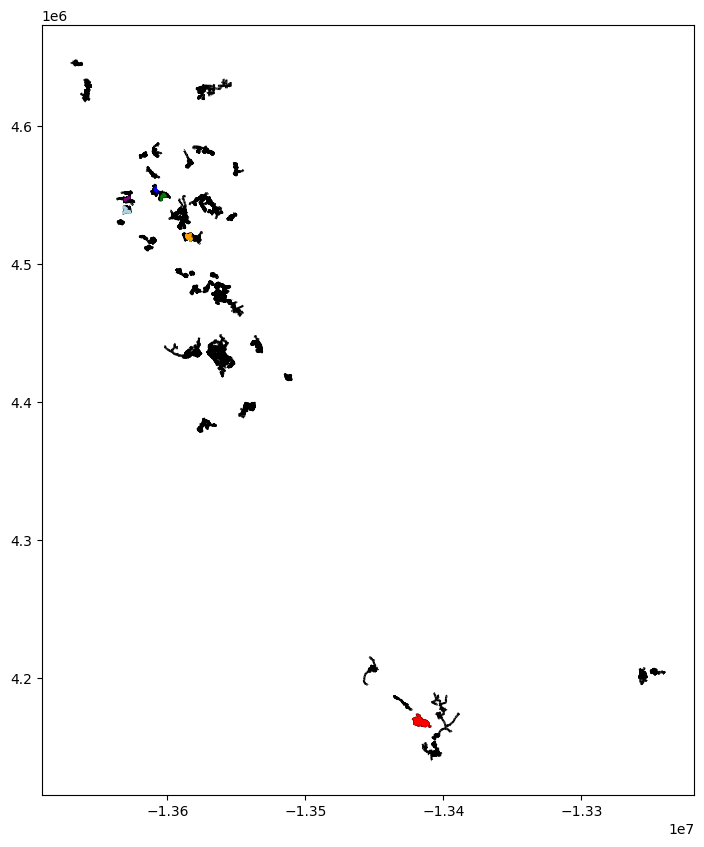

In [17]:
most_customers = gpd.GeoDataFrame(top_5_feeders_customers, geometry='geometry')
most_customers_gdf = most_customers.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
most_customers_gdf.plot(ax=ax, marker='o', color='black', markersize=50, label='Feeders')

for i, (feeder, name) in enumerate(zip(most_customers_gdf.geometry, most_customers_gdf['Feeder_Name'])):
    label = f'{name}'
    gpd.GeoSeries([feeder]).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100, label=label)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title('Feeders Locations with Most Customers (PG&E)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make space for the legend

plt.show()


### 6.2 Least customers

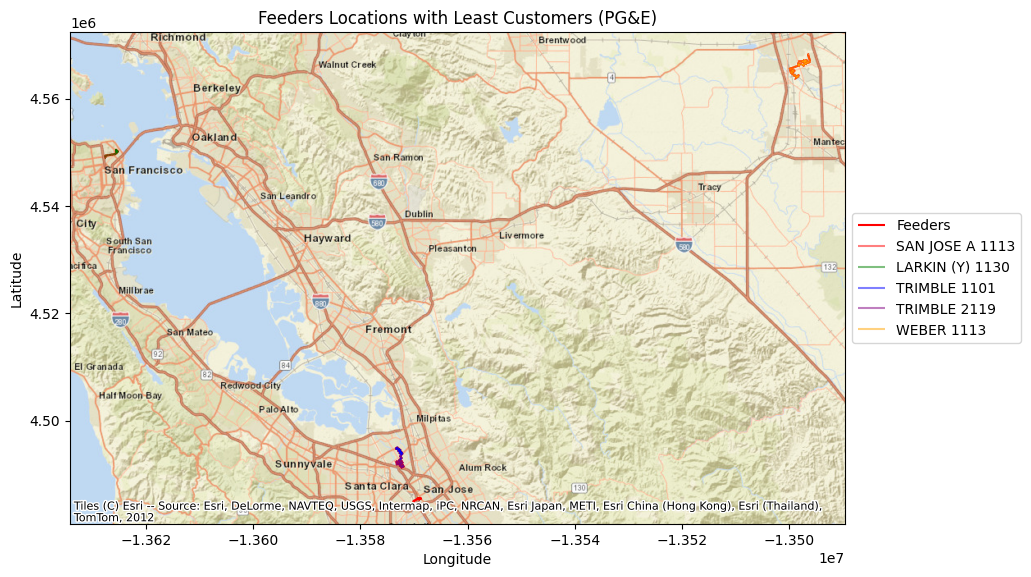

In [ ]:
least_customers = gpd.GeoDataFrame(bottom_5_feeders_customers, geometry='geometry')
least_customers_gdf = least_customers.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
least_customers_gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Feeders')

for i, (feeder, name) in enumerate(zip(least_customers_gdf.geometry, least_customers_gdf['Feeder_Name'])):
    label = f'{name}'
    gpd.GeoSeries([feeder]).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100, label=label)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Feeders Locations with Least Customers (PG&E)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


### 6.3 Greatest capacity

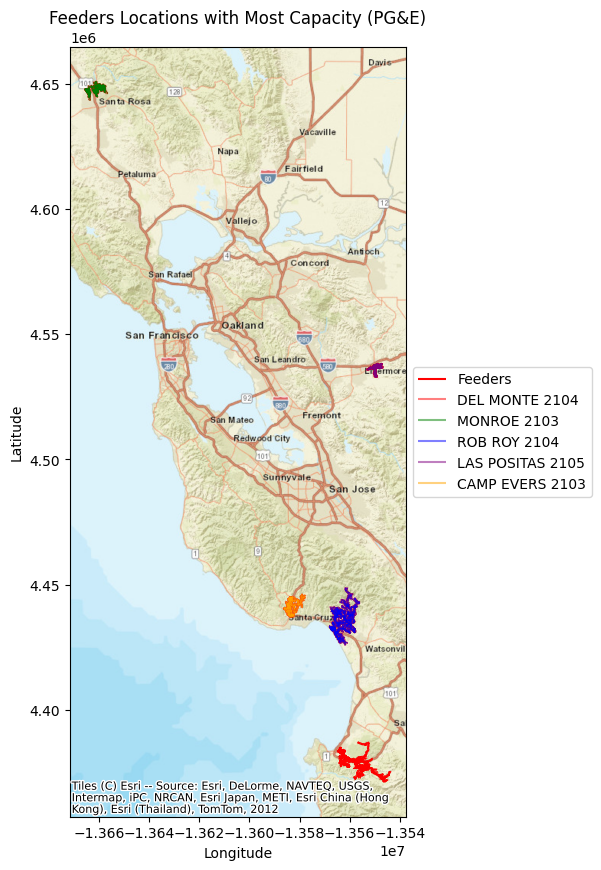

In [ ]:
greatest_capacity = gpd.GeoDataFrame(top_capacity_feeders_selected, geometry='geometry')
greatest_capacity_gdf = greatest_capacity.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
greatest_capacity_gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Feeders')

for i, (feeder, name) in enumerate(zip(greatest_capacity_gdf.geometry, greatest_capacity_gdf['Feeder_Name'])):
    label = f'{name}'
    gpd.GeoSeries([feeder]).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100, label=label)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Feeders Locations with Most Capacity (PG&E)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()



### 6.3 Lowest capacity

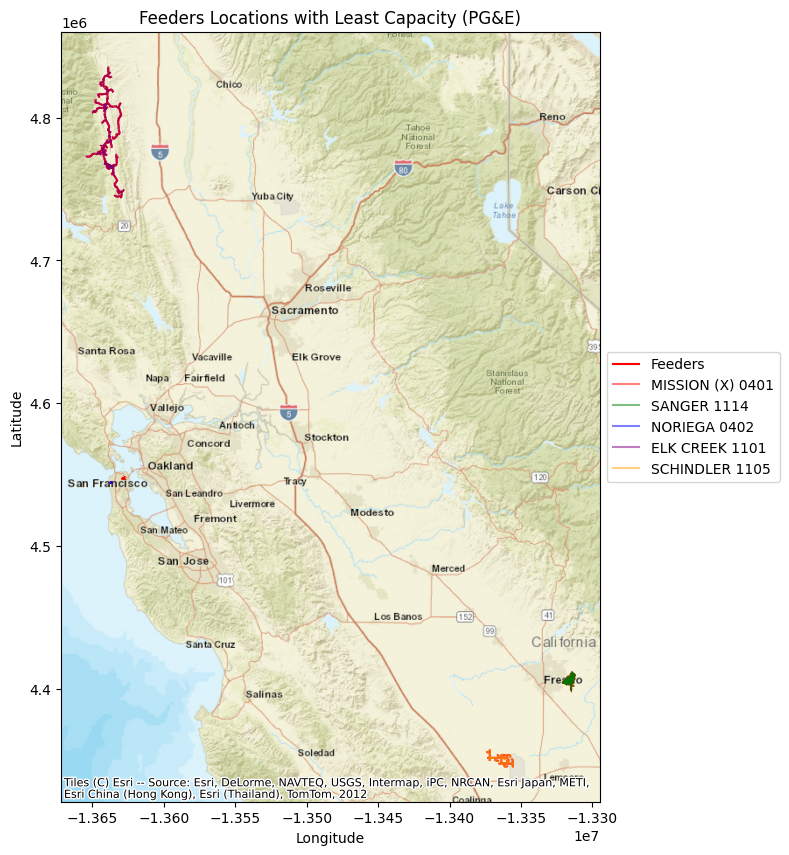

In [ ]:
lowest_capacity = gpd.GeoDataFrame(lowest_capacity_feeders_selected, geometry='geometry')
lowest_capacity_gdf = lowest_capacity.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
lowest_capacity_gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Feeders')

for i, (feeder, name) in enumerate(zip(lowest_capacity_gdf.geometry, lowest_capacity_gdf['Feeder_Name'])):
    label = f'{name}'
    gpd.GeoSeries([feeder]).plot(ax=ax, color=colors[i], alpha=0.5, markersize=100, label=label)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Feeders Locations with Least Capacity (PG&E)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()